In [12]:
import cv2
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import sklearn
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data.sampler import SubsetRandomSampler

### Tranforms

The transforms are used to alter and manipulate the image. This alters the images so that the images are loaded in the same size if they are different. 

In [3]:
import os
print(os.listdir('C:/Users/Kaushik/Documents/akash files/fruit-classifier-master/fruit-classifier-master/datasets/training'))

['Apple Crimson Snow', 'Apple Red', 'Banana', 'Lemon', 'Orange']


In [6]:
transfrom =  transforms.Compose([transforms.RandomRotation(30),
                                 transforms.RandomResizedCrop(244),
                                 transforms.RandomVerticalFlip(),
                                 transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.255])])

In [8]:
img_dir = "C:/Users/Kaushik/Documents/akash files/fruit-classifier-master/fruit-classifier-master/datasets/training"
train_data = datasets.ImageFolder(img_dir,transform = transform)

Train_set is the dataset which will contain the images. The dataset is loaded in batches of 32 to dataloader.
Test_set will have the test data.

In [46]:
img_test_dir = "C:/Users/Kaushik/Documents/akash files/fruit-classifier-master/fruit-classifier-master/datasets/test"
test_data = datasets.ImageFolder(img_test_dir, transform = transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 32, num_workers = num_workers)

In [47]:
num_workers = 0
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size)*num_train))

valid_idx,train_idx = indices[:valid_split], indices[valid_split:]

print('Length of validation set: ',len(valid_idx))
print('Length of train set: ',len(train_idx))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64,
                                          sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
                                           sampler=valid_sampler, num_workers=num_workers)


Length of validation set:  479
Length of train set:  1918


In [14]:
classes=('Apple Crimson Snow','Apple Red','Banana', 'Lemon', 'Orange')

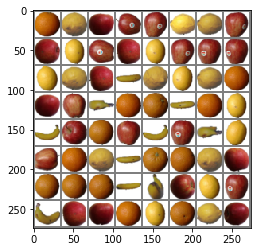

Orange, Lemon, Apple Crimson Snow, Apple Red, Apple Red, Lemon, Lemon, Apple Red, Apple Crimson Snow, Lemon, Apple Red, Apple Crimson Snow, Lemon, Apple Red, Apple Red, Apple Red, Lemon, Lemon, Apple Crimson Snow, Banana


In [48]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(', '.join('%5s' % classes[labels[j]] for j in range(20)))

In [54]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 5)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=5, bias=True)
  (dropout): Dropout(p=0.25)
)


In [55]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [56]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f})'.format(
        valid_loss_min,
        valid_loss))
print("Fucking training completed")

Epoch: 1 	Training Loss: 1.252711 	Validation Loss: 0.276550
Validation loss decreased (inf --> 0.276550)
Epoch: 2 	Training Loss: 0.522442 	Validation Loss: 0.017947
Validation loss decreased (inf --> 0.017947)
Epoch: 3 	Training Loss: 0.015607 	Validation Loss: 0.000055
Validation loss decreased (inf --> 0.000055)
Epoch: 4 	Training Loss: 0.003394 	Validation Loss: 0.001247
Validation loss decreased (inf --> 0.001247)
Epoch: 5 	Training Loss: 0.001782 	Validation Loss: 0.000013
Validation loss decreased (inf --> 0.000013)
Epoch: 6 	Training Loss: 0.001039 	Validation Loss: 0.000013
Validation loss decreased (inf --> 0.000013)
Epoch: 7 	Training Loss: 0.000339 	Validation Loss: 0.000010
Validation loss decreased (inf --> 0.000010)
Epoch: 8 	Training Loss: 0.000433 	Validation Loss: 0.000007
Validation loss decreased (inf --> 0.000007)
Epoch: 9 	Training Loss: 0.000882 	Validation Loss: 0.000101
Validation loss decreased (inf --> 0.000101)
Epoch: 10 	Training Loss: 0.002190 	Validation

In [60]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.004174

Test Accuracy of     0: 100% (148/148)
Test Accuracy of     1: 100% (164/164)
Test Accuracy of     2: 100% (166/166)
Test Accuracy of     3: 100% (164/164)
Test Accuracy of     4: 100% (160/160)


IndexError: list index out of range

TypeError: 'DataLoader' object does not support indexing